In [ ]:
%matplotlib inline

# CenterNet (AkidaNet18)/PASCAL-VOC detection example

This example demonstrates Akida's object detection capabilities using the CenterNet (AkidaNet18) architecture.

### 1. Import model

The model used for this demonstration can be found at the [Akida 2.0 Model Zoo](https://doc.brainchipinc.com/model_zoo_performance.html#id4). It has been pre-downloaded and converted to Akida here for efficiency.

In [ ]:
from akida import Model

model_akida = Model("models/centernet_akidanet18_voc_384_i8_w8_a8.fbz")
model_akida.summary()

### 2. Map the model onto the FPGA

For more details on this flow, please see: [Model Hardware Mapping](https://doc.brainchipinc.com/user_guide/akida.html#model-hardware-mapping)

In [ ]:
import akida
from cnn2snn import set_akida_version, AkidaVersion
# Instantiate akida model
with set_akida_version(AkidaVersion.v2):
    devices = akida.devices()
    if len(devices) > 0:
        print(f'Available devices: {[dev.desc for dev in devices]}')
        device = devices[0]
        print(device.version)
        try:
            model_akida.map(device)
            print(f"Mapping to Akida device {device.desc}.")
        except Exception as e:
            print("Model not compatible with FPGA. Running on CPU.")
    else:
        print("No Akida devices found, running on CPU.")


#### Model Summary After Mapping

In [ ]:
model_akida.summary()

### 3 Run inference on a image

Here, an image is preprocessed and evaluated through the Akida model. Bounding boxes for detected objects are returned and superimposed on the image using the anchors.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from akida_models.detection.processing import preprocess_image
from akida_models.centernet.centernet_processing import decode_output

import cv2

# PASCAL VOC object detection class labels
labels = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
         'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
         'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
         'train', 'tvmonitor']

# Get model input dimensions
input_shape = model_akida.layers[0].input_dims

# Load and preprocess input image
raw_image = cv2.imread("img/train.jpg")
raw_height, raw_width, _ = raw_image.shape

# Preprocess image for model input
image = preprocess_image(raw_image, input_shape)
input_image = image[np.newaxis, :].astype(np.uint8)

output_img = np.copy(raw_image)

# Run object detection inference
pots = model_akida.predict(input_image)[0]

# Decode predictions to bounding boxes
bounding_boxes = decode_output(pots,
                       20,  # Number of classes
                       obj_threshold=0.4,  # Confidence threshold
                       max_detections=100,
                       kernel=5)

# Draw bounding boxes and labels on output image
for box in bounding_boxes:
       # Draw rectangle around detected object
        output_img = cv2.rectangle(output_img, 
                   (int(box.x1 * raw_width), int(box.y1 * raw_height)),
                   (int(box.x2 * raw_width), int(box.y2 * raw_height)),
                   color=(0, 255, 0),  # Green box
                   thickness=2)
        label_text = labels[box.get_label()]
        font = cv2.FONT_HERSHEY_DUPLEX
        font_scale = 0.8
        thickness = 2
        
        # Get text size for background rectangle
        (text_width, text_height), baseline = cv2.getTextSize(label_text, font, font_scale, thickness)
        
        # Draw background rectangle
        text_x = int(box.x1 * raw_width)
        text_y = int(box.y1 * raw_height - 10)
        output_img = cv2.rectangle(output_img,
                                  (text_x, text_y - text_height - baseline),
                                  (text_x + text_width, text_y + baseline),
                                  (0, 0, 0),  # Black background
                                  -1)  # Filled rectangle
        
        # Draw text on background
        output_img = cv2.putText(output_img,
                        label_text,
                        (text_x, text_y),
                        font,
                        font_scale,
                        (255, 255, 255),  # White text
                        thickness)

  

# Display results
fig = plt.figure(num='VOC detection by Akida')
ax = fig.subplots(1)
img_plot = ax.imshow(np.zeros(output_img.shape, dtype=np.uint8))
img_plot.set_data(output_img)

plt.axis('off')
plt.show()

### 4 Model Statistics

The advantage of running on a FPGA is the ability to accurately calculate performance, power and area metrics for a given model and process node.

Here are example calculations for the CenterNet model that was tested above.

#### Performance

This Akida 6-Node FPGA is running at __25 MHz__. Based on that knowledge, we need to know the frames per second on the FPGA. The `akida.Model.statistics.fps` will return this value.

In [ ]:
akida_fpga_mhz = 25  # MHz
fps = model_akida.statistics.fps
print(f"FPS @ {akida_fpga_mhz} MHz: {fps}")

To estimate frames per second at a different frequency use the calculation:

$$ \frac{\text{estimated\_fps}}{\text{estimated\_mhz}} = \frac{\text{fps}}{\text{akida\_fpga\_mhz}}$$

$$\text{estimated\_fps} = \frac{\text{fps} \times \text{estimated\_mhz}}{\text{akida\_fpga\_mhz}} $$


In [ ]:
estimated_mhz = 400  # Change this to your desired frequency
estimated_fps = (fps * estimated_mhz) / akida_fpga_mhz
print(f"Estimated FPS @ {estimated_mhz} MHz: {estimated_fps}")

#### Power

Estimating power consumption of a model involves understanding the architecture and size of the model (e.g. # parameters, types of layer operations, etc) as well as a target process node (e.g. TSMC 28nm, Global Foundry 22nm, etc) and target chip frequency (e.g. 400 MHz, 1 GHz, etc).

Brainchip's Solution Architects have access to up to date calculations for the Akida 2.0 Register-transfer-level (RTL) and can perform estimates for your particular model. Contact your BrainChip representative when you have a model ready for estimating.


#### Area

Similar to power, estimating the area size required for a chip to run a model involves understanding the architecture and size of the model (e.g. # parameters, types of layer operations, etc) as well as a target process node (e.g. TSMC 28nm, Global Foundry 22nm, etc) and the ability to leverage RTL options such Hardware Partial Reconfiguration.

A model that executes successfully on the FPGA is capable of receiving accurate sizing estimations. BrainChip's Solution Architects can assist with these calculations.

### 5 Release the Akida FPGA device to free it up for further experiments.

Uncomment the code in the cell below and run the cell.

In [ ]:
# import os
# os._exit(00)

(You can also use this button to reset your kernel)

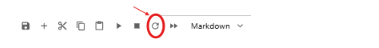